In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
BTC_USD = yf.download("BTC-USD",start="2022-04-01",end ="2022-05-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-31,47062.148438,47512.027344,45390.539062,45538.675781,45538.675781,33327427106
2022-04-01,45554.164062,46616.242188,44403.140625,46281.644531,46281.644531,38162644287
2022-04-02,46285.500000,47028.281250,45782.511719,45868.949219,45868.949219,29336594194
2022-04-03,45859.128906,47313.476562,45634.105469,46453.566406,46453.566406,25414397610
2022-04-04,46445.273438,46791.089844,45235.816406,46622.675781,46622.675781,32499785455


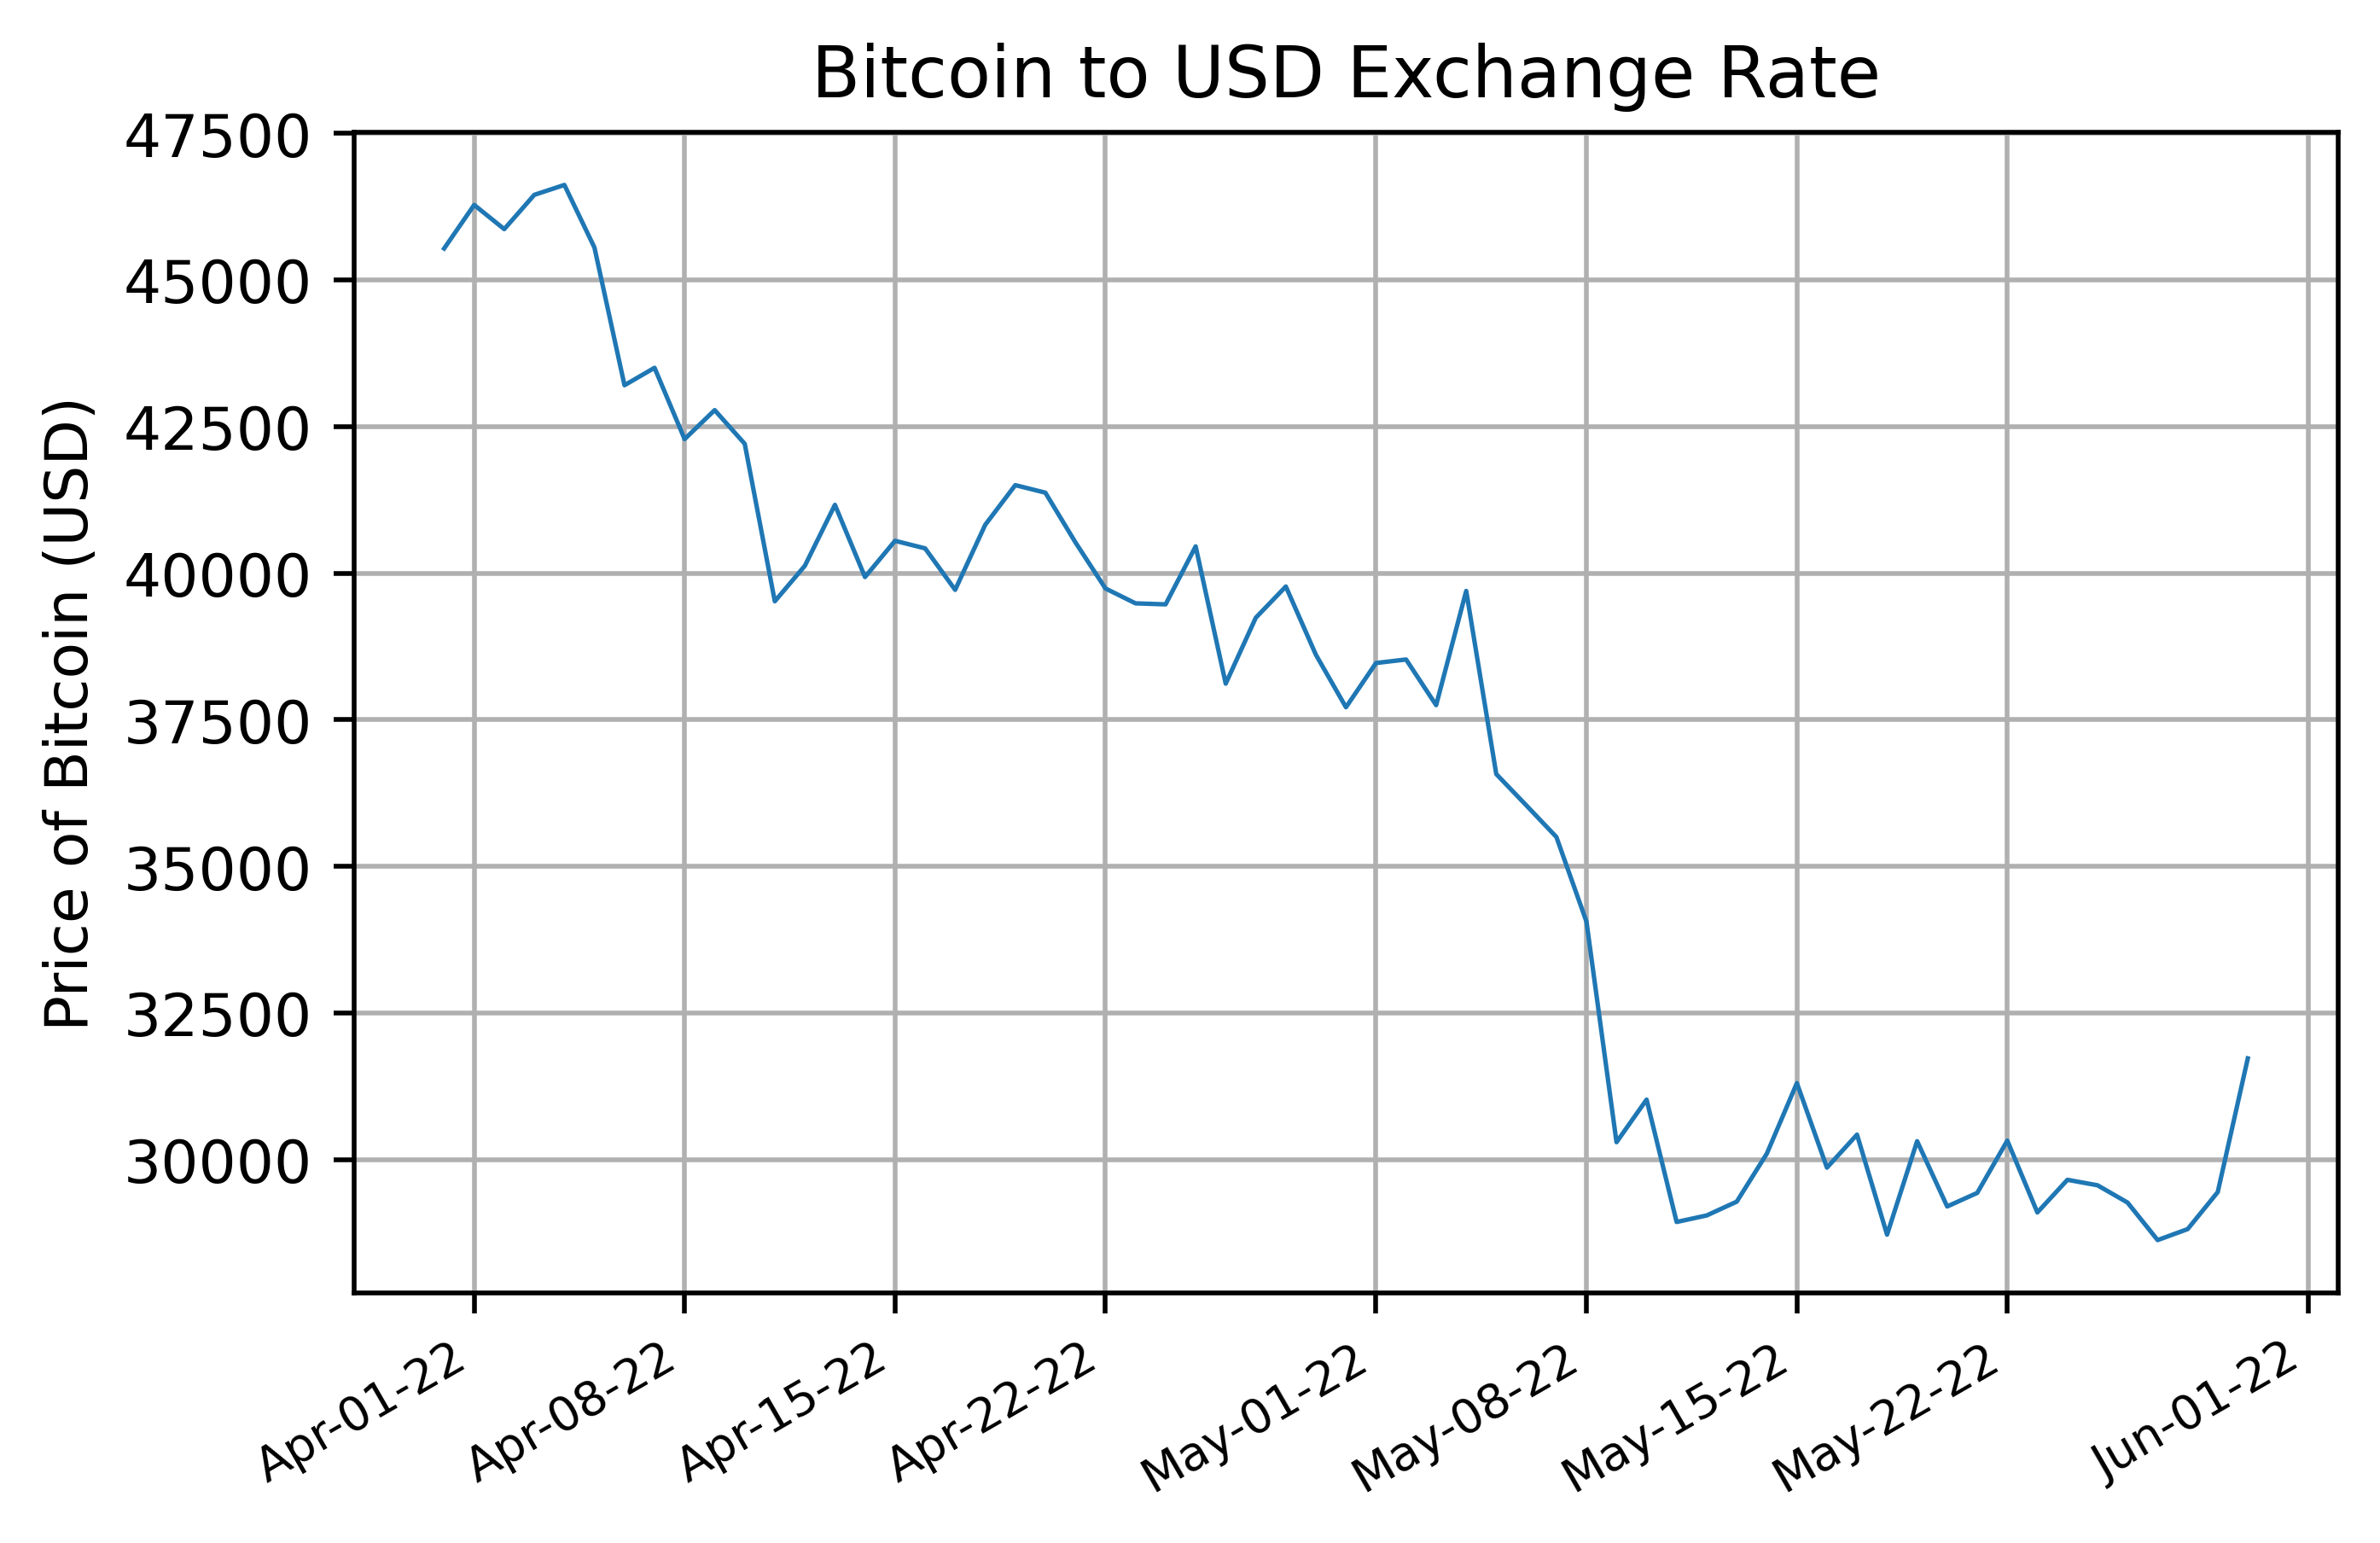

In [10]:
fig, ax = plt.subplots(dpi=500)
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75)
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid()

plt.show()

In [13]:
BTC_USD['SMA_9'] = BTC_USD['Close'].rolling(window=9, min_periods=1).mean()
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window=30, min_periods=1).mean()


In [14]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_30
Date,,,,,,,,
2022-05-26,29564.777344,29834.160156,28261.906250,29267.224609,29267.224609,36774325352,29508.375217,32927.392578
2022-05-27,29251.140625,29346.943359,28326.613281,28627.574219,28627.574219,36582005748,29498.075521,32573.607682
2022-05-28,28622.625000,28814.900391,28554.566406,28814.900391,28814.900391,35519577634,29331.471788,32208.310091
2022-05-29,29019.867188,29498.009766,28841.107422,29445.957031,29445.957031,18093886409,29358.718099,31902.847852
2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,31726.390625,39277993274,29613.625217,31703.231706


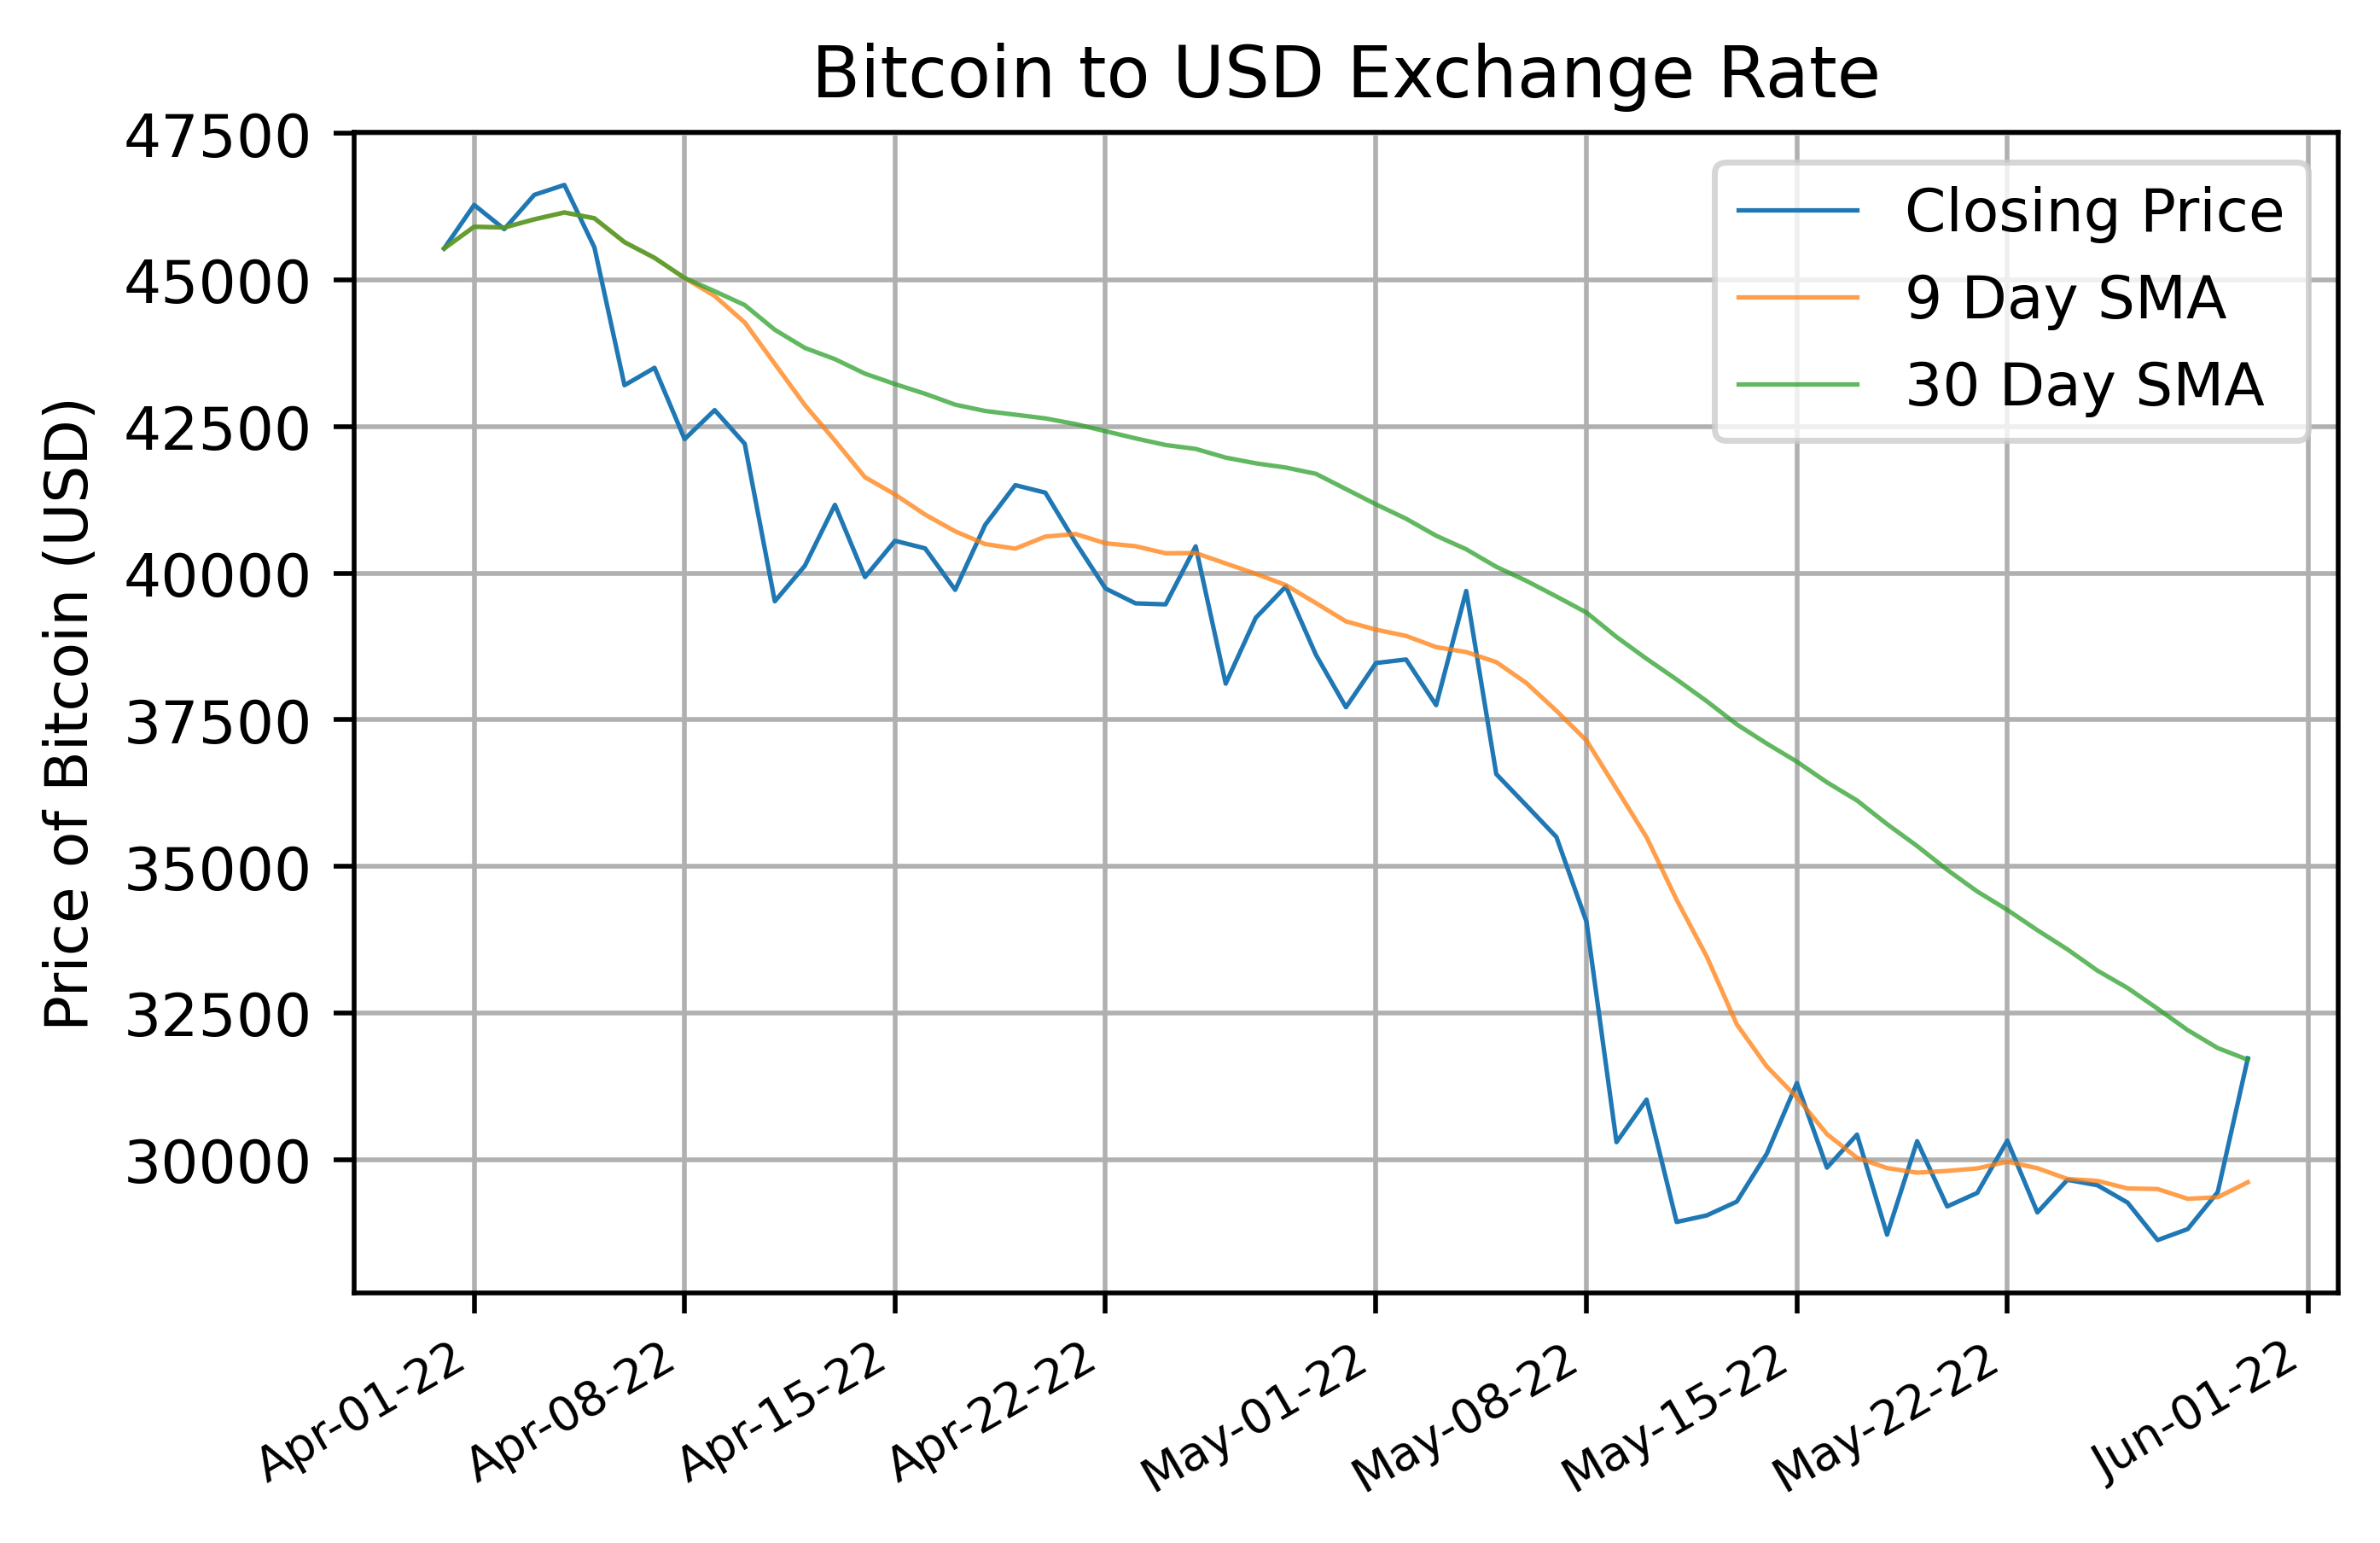

In [23]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price') # Added label

"""
You have already seen the code above earlier - we are simply reusing it.
Below we plot the 9 and 30 day Simple Moving Averages and give them the appropriate label
"""
ax.plot(BTC_USD['SMA_9'], lw=0.75,alpha=0.75,label='9 Day SMA')
ax.plot(BTC_USD['SMA_30'], lw=0.75,alpha=0.75,label='30 Day SMA')


# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()

In [38]:
# Create a pandas dataframe that is the same size as the BTC_USD dataframe and covers the same dates
trade_signals = pd.DataFrame(index=BTC_USD.index)

# Define the intervals for the Fast and Slow Simple Moving Averages (in days)
short_interval = 1
long_interval = 4

# Compute the Simple Moving Averages and add it to the dateframe as new columns
trade_signals['Short'] = BTC_USD['Close'].rolling(window=short_interval, min_periods=1).mean()
trade_signals['Long'] = BTC_USD['Close'].rolling(window=long_interval, min_periods=1).mean()

In [39]:
# Create a new column populated with zeros
trade_signals['Signal'] = 0.0

# Wherever the Shorter term SMA is above the Longer term SMA, set the Signal column to 1, otherwise 0
trade_signals['Signal'] = np.where(trade_signals['Short'] > trade_signals['Long'], 1.0, 0.0)   

In [40]:
trade_signals['Position'] = trade_signals['Signal'].diff()

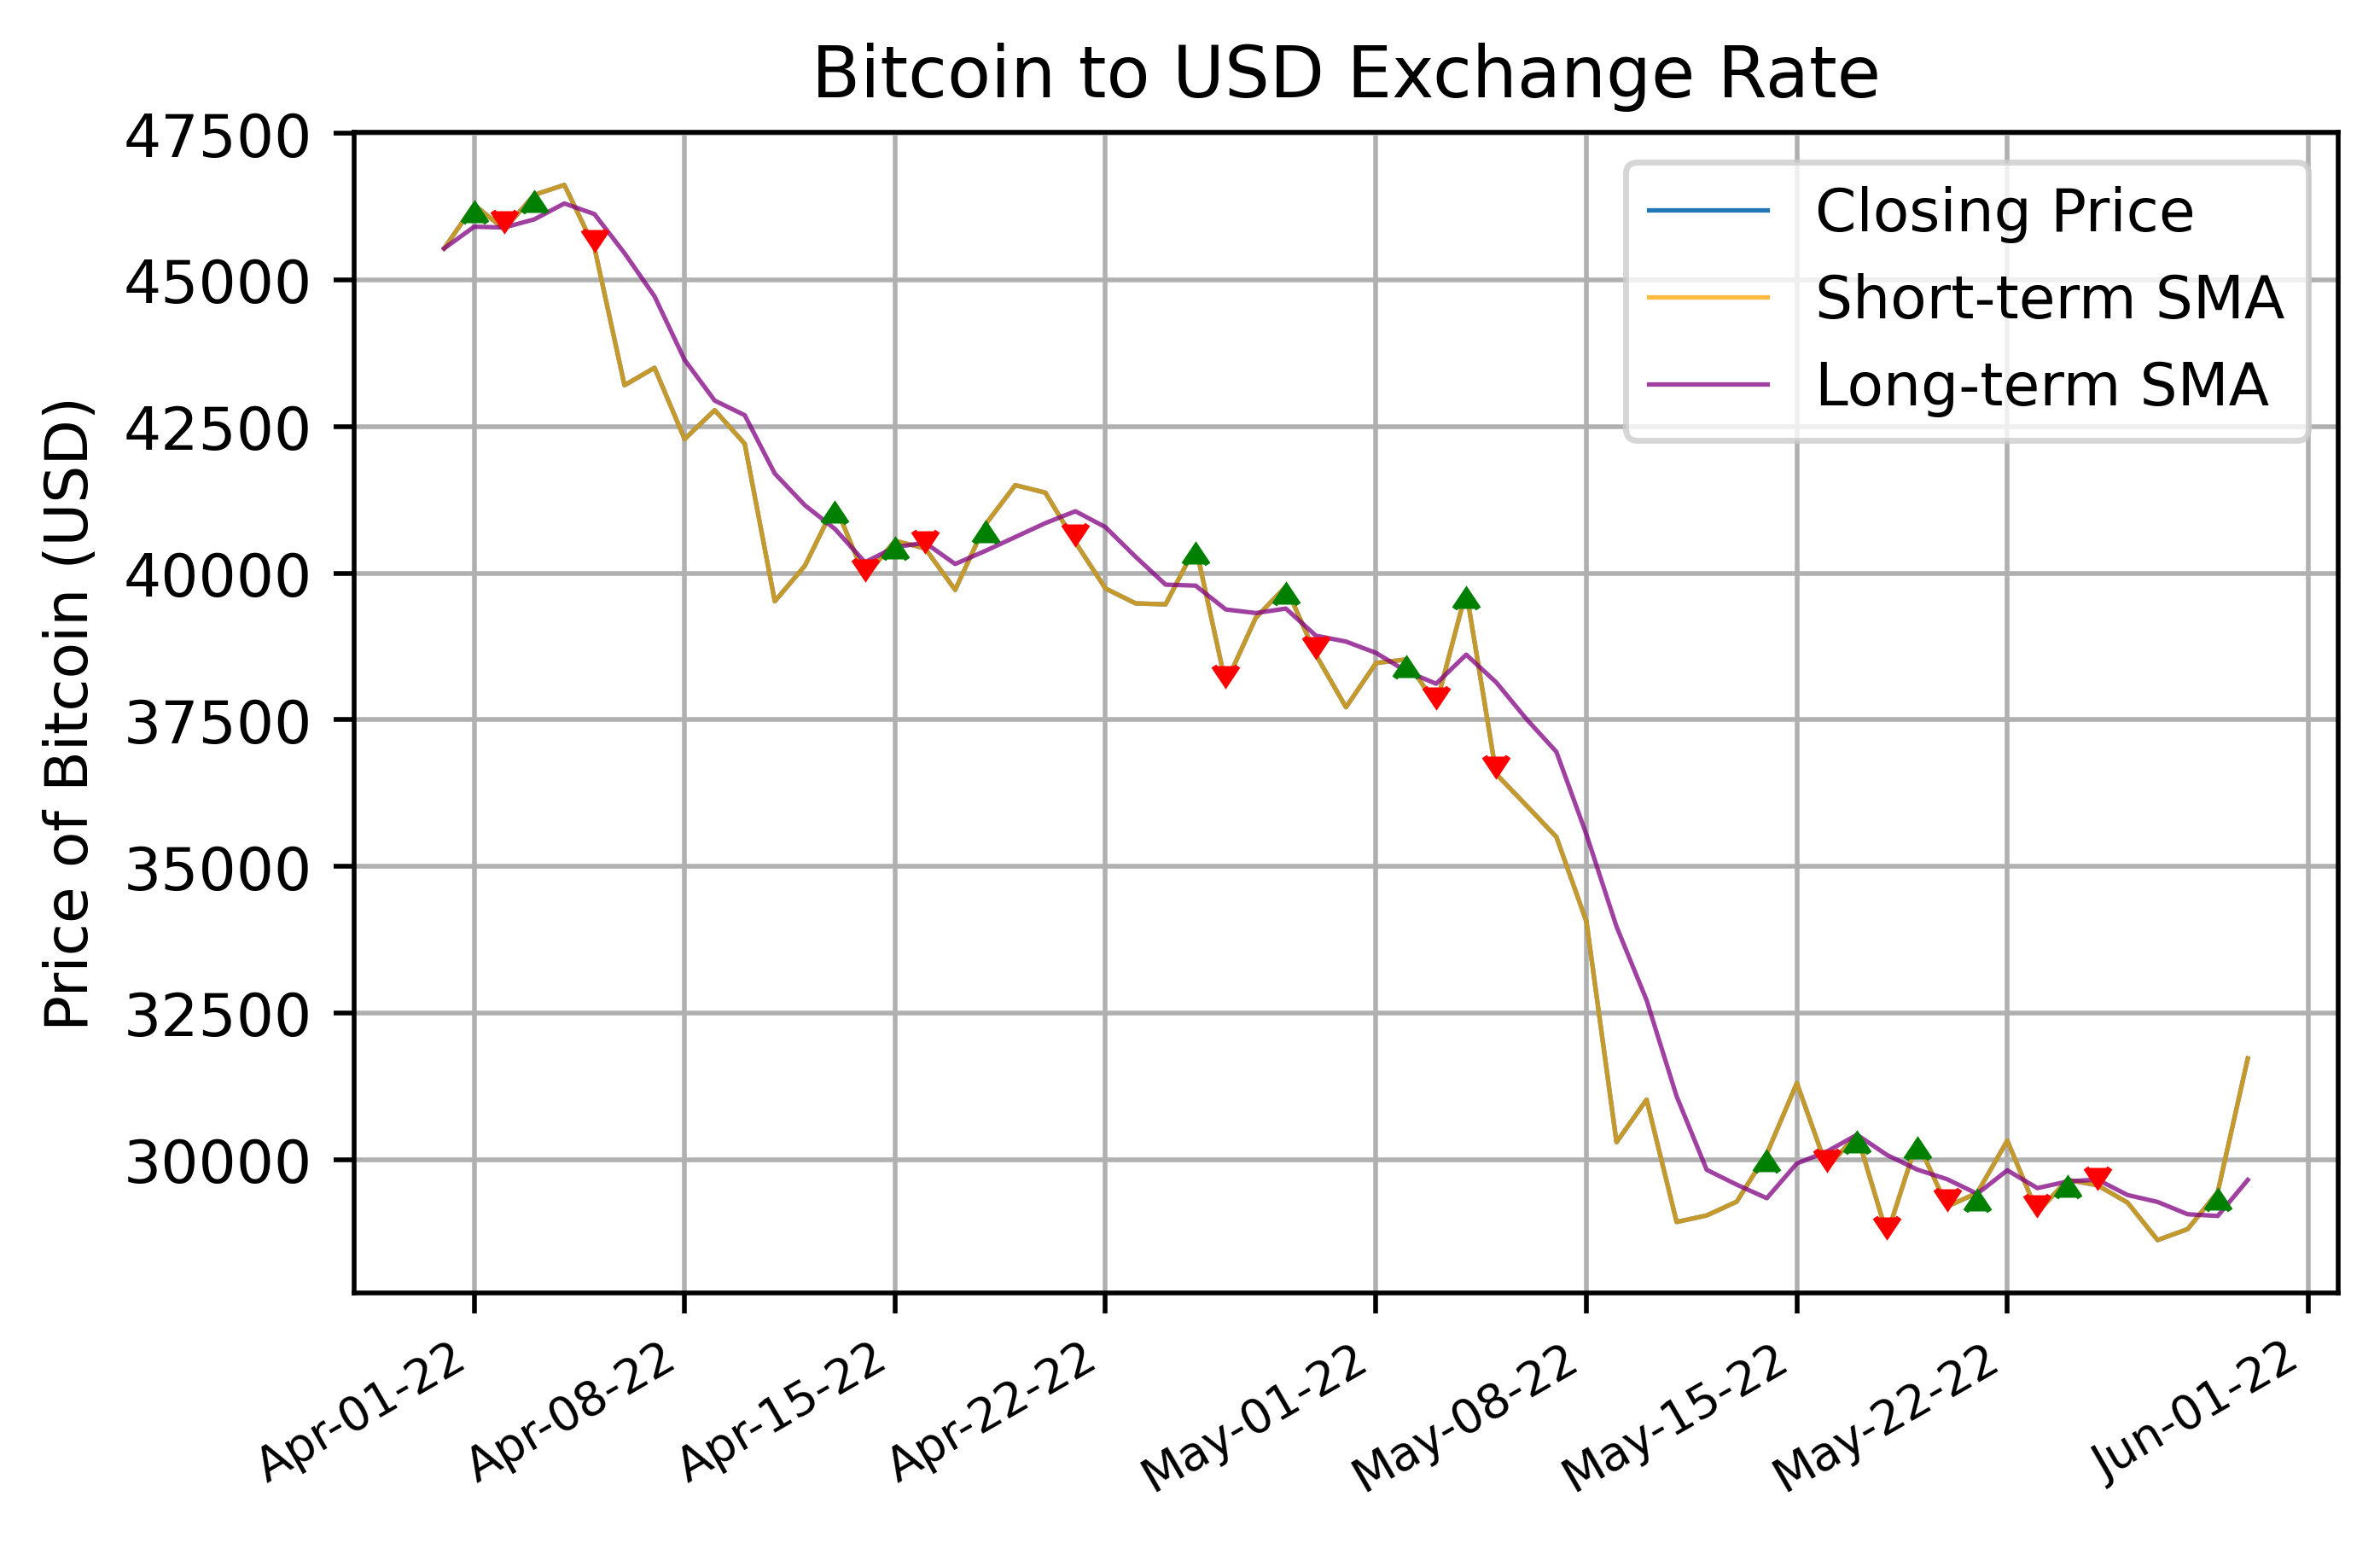

In [41]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()


# Plotting the Bitcoin closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price')

# Plot the shorter-term moving average
ax.plot(trade_signals['Short'], lw=0.75, alpha=0.75, color='orange', label='Short-term SMA')

# Plot the longer-term moving average
ax.plot(trade_signals['Long'], lw=0.75, alpha=0.75, color='purple', label='Long-term SMA')


# Adding green arrows to indicate buy orders
ax.plot(trade_signals.loc[trade_signals['Position']==1.0].index, trade_signals.Short[trade_signals['Position'] == 1.0],
 marker=6, ms=4, linestyle='none', color='green')

 # Adding red arrows to indicate sell orders
ax.plot(trade_signals.loc[trade_signals['Position'] == -1.0].index, trade_signals.Short[trade_signals['Position'] == -1.0],
 marker=7, ms=4, linestyle='none', color='red')


# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()

In [42]:
# Define how much money you will start with (in USD)
initial_balance = 10000.0 # ten thousand USD

# Create dataframe containing all the dates considered
backtest = pd.DataFrame(index=trade_signals.index)

# Add column containing the daily percent returns of Bitcoin
backtest['BTC_Return'] = BTC_USD['Close'] / BTC_USD['Close'].shift(1) # Current closing price / yesterday's closing price


In [43]:

# Add column containing the daily percent returns of the Moving Average Crossover strategy
backtest['Alg_Return'] = np.where(trade_signals.Signal == 1, backtest.BTC_Return, 1.0)

# Add column containing the daily value of the portfolio using the Crossover strategy
backtest['Balance'] = initial_balance * backtest.Alg_Return.cumprod() # cumulative product

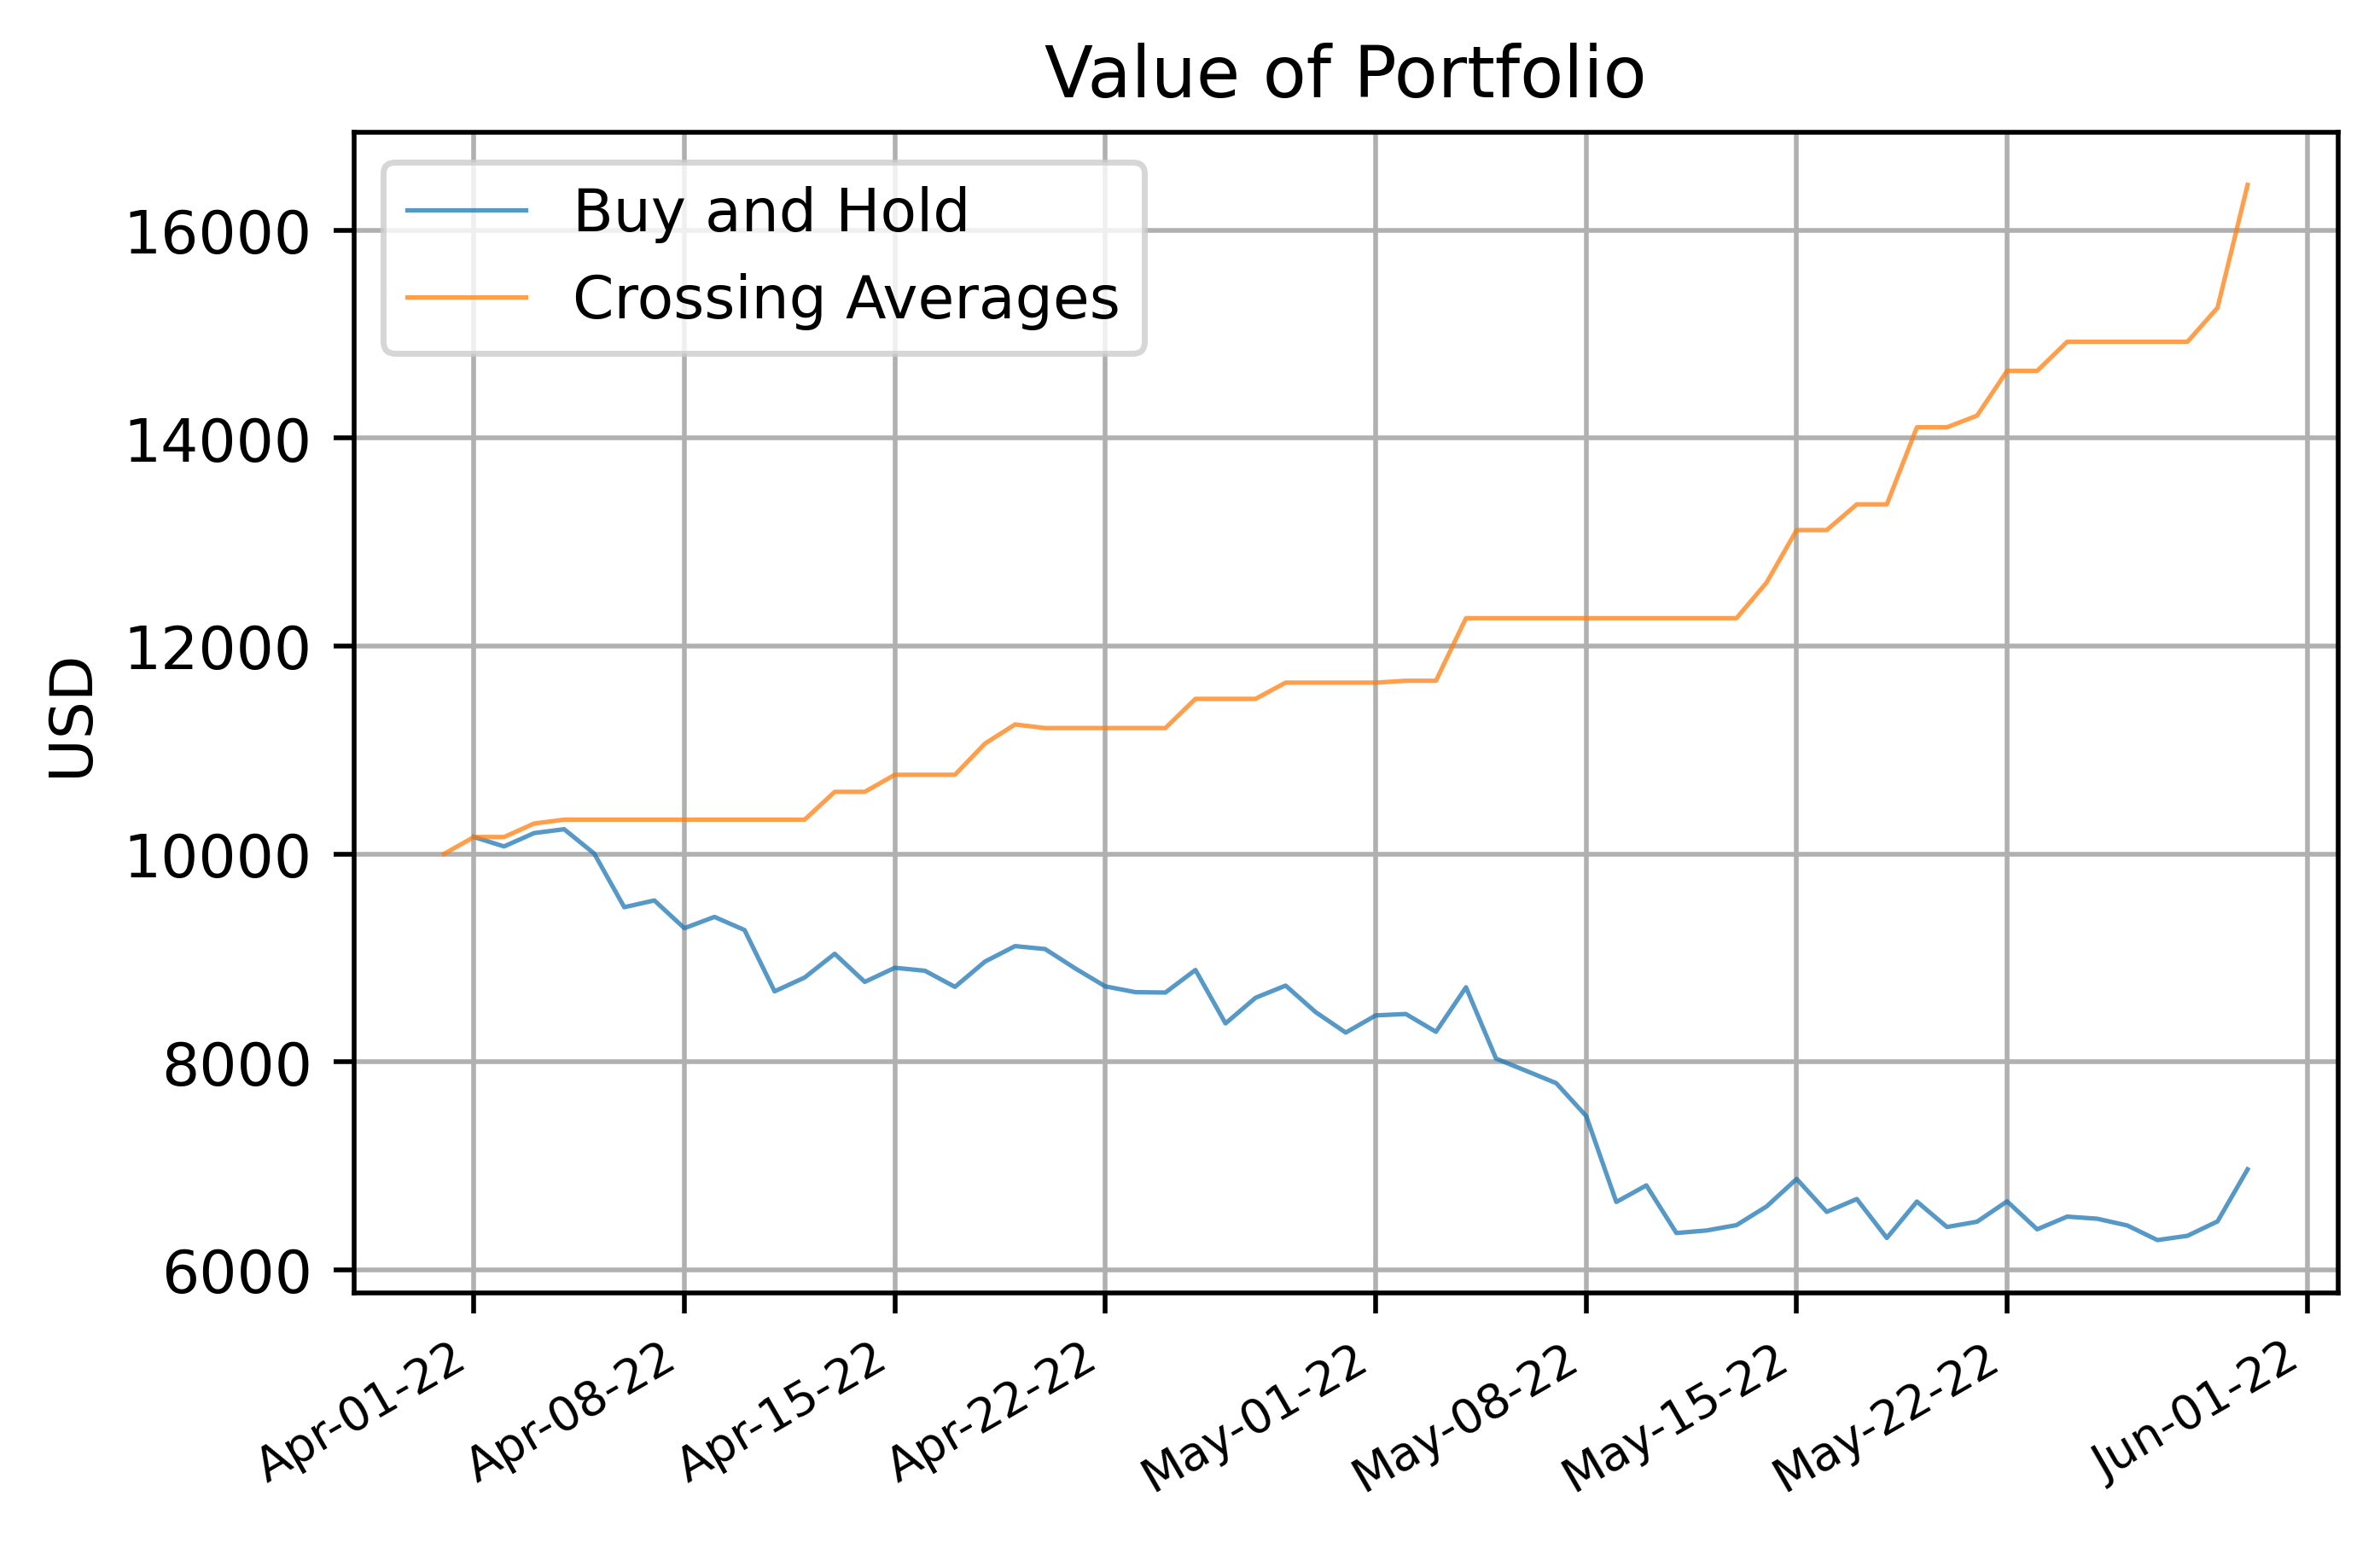

In [44]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the value of Buy and Hold Strategy
ax.plot(initial_balance*backtest.BTC_Return.cumprod(), lw=0.75, alpha=0.75, label='Buy and Hold')

# Plotting total value of Crossing Averages Strategy
ax.plot(backtest['Balance'], lw=0.75, alpha=0.75, label='Crossing Averages')

# Adding labels and title to the plot
ax.set_ylabel('USD')
ax.set_title('Value of Portfolio')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()